In [1]:
import sys
import os
import copy
import traceback

########################
# Find qslam modules
########################
sys.path.append('../qslam')
sys.path.append('../paduaq')

from qslamdesignparams import GLOBALDICT
from riskanalysis import CreateQslamExpt as riskqslam
from riskanalysis import CreateNaiveExpt as risknaive
from riskanalysis import EngineeredTruth
from visualiserisk import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


from pdinter_MM import pd_interpolant, calc_padua_cgl
from true_functions import true_function, generate_data_qubits_coords
from pdpoints import dims_padua_set

sys.path.append('./')

In [2]:
########################
# Analysis parameters
########################

INFTYPE = 'expinf'
# SSIM
# Default Cone Ctwo too large for this application of ssim score. Decrease by factor of 100. 
Cone=0.000001
Ctwo=0.000001

data_qubit_num = 25
data_qubit_flag ='uniform'
TUNING_MULTIPLIER=5
trials=50

########################
# Save/Load to path 
########################

PATHDICT['pdir'] = './data/' # load path

if INFTYPE == 'expinf':
    save_to_path = './data_expinf'
    INFTYPE = 'expinf_' # hack to compute std in inf scores

if INFTYPE == 'maxinf':
    save_to_path = './data_maxinf'

In [3]:
########################
# Set Simulation Params
########################

Multiples = [1, 3, 5, 7, 9, 10, 15, 20, 50]

########################
# Set True Field
########################

from tuningresults_nonpoly import SIMULATIONSDICT as cheb2fun
from tuningresults_linear import SIMULATIONSDICT as linear
from tuningresults_franke import SIMULATIONSDICT as uniform
from tuningresults_franke_2 import SIMULATIONSDICT as franke

opt_method = "Uniform" # SIMULATIONSDICT[padua_order]["Opt_Beta_Expn"] 
max_msmtvar = len(Multiples)

SIM_DICT_LABELS =['franke', 'lin', 'cheb2fun', 'franke_2']
SIM_DICT_LIST = [ uniform, linear, cheb2fun, franke]

GRID_ORDER = [-1, -4, -5, -3, -6, -2, 1, 2, 3, 4, 5, 10]
PICK_PADUA_ORDER=6
REG_SCALING = np.asarray([4, 9, 16, 36, 56])
PADUA_ORDER = np.asarray(GRID_ORDER[PICK_PADUA_ORDER:])
NUM_SENSOR_QUBITS = [dims_padua_set(idx_order)for idx_order in PADUA_ORDER]

In [4]:
########################
# Run Script
######## ###############

In [5]:

def get_keys(padua_order, true_function_type):

    if padua_order > 0:
        prefix = true_function_type +'_padua_ord_'+str(padua_order)+'_'

    if padua_order == -1: 
        prefix = true_function_type +'_no_padua_'
        padua_order = "no_padua"

    if padua_order == -2:
        prefix = true_function_type +'_regfine_'
        padua_order = "regfine"

    if padua_order == -3:
        prefix = true_function_type +'_regcoarse_'
        padua_order = "regcoarse"

    if padua_order == -4:
        prefix = true_function_type +'_reg4_'
        padua_order = "reg4"

    if padua_order == -5:
        prefix = true_function_type +'_reg9_'
        padua_order = "reg9"

    if padua_order == -6:
        prefix = true_function_type +'_reg36_'
        padua_order = "reg36"
    
    return prefix, padua_order

In [6]:
data_labels=['qslam_rms', 'naive_rms', 'qslam_ssim', 'naive_ssim', 'qslam_inf', 'naive_inf']
qslam_rms, naive_rms, qslam_ssim, naive_ssim, qslam_inf, naive_inf = [], [], [], [], [], []

for idx_case in range(len(SIM_DICT_LIST)):
    
    SIMULATIONSDICT = SIM_DICT_LIST[idx_case]
    
    for idx_grid in range(len(GRID_ORDER)):
        
        prefix, padua_order = get_keys(GRID_ORDER[idx_grid], SIM_DICT_LABELS[idx_case])
    
        idx_1 = SIMULATIONSDICT[padua_order][opt_method]["optimal"]["idx_1"]
        idx_2 = SIMULATIONSDICT[padua_order][opt_method]["optimal"]["idx_2"]
        idx_3 = SIMULATIONSDICT[padua_order][opt_method]["optimal"]["idx_3"]

        fname_likelihood = 'optidx_'+str(idx_1)+'_'+str(idx_2)+'_'+str(idx_3)

        for idx_msmt_var in Multiples:

            unique_ID = prefix + fname_likelihood + '_m_' + str(idx_msmt_var) 
            PATHDICT["fle"] = unique_ID

            qslamdata = np.load(path_to_file(PATHDICT, flag='q'))
            naivedata = np.load(path_to_file(PATHDICT, flag='n'))

            perqubit_qslamdata = np.sqrt(np.mean(qslamdata['macro_residuals'][0]**2, axis= 1)) / np.pi
            qslam_rms.append(perqubit_qslamdata)
            perqubit_naivedata = np.sqrt(np.mean(naivedata['macro_residuals'][0]**2, axis= 1)) / np.pi
            naive_rms.append(perqubit_naivedata)

            qslam_ssim.append(Metric.ssim(qslamdata, Cone=0.001, Ctwo=0.001)[1])
            naive_ssim.append(Metric.ssim(naivedata, Cone=0.001, Ctwo=0.001)[1])

            qslam_inf.append(Metric.infnorm(qslamdata["macro_residuals"], e_type=INFTYPE))
            naive_inf.append(Metric.infnorm(naivedata["macro_residuals"], e_type=INFTYPE))
    
for dataset in data_labels:
    vars()[dataset] = np.asarray(vars()[dataset]).reshape(len(SIM_DICT_LIST), len(GRID_ORDER), len(Multiples), trials)

for dataset in data_labels:
    
    vars()[dataset+'_exp_loss'] = np.nanmean(vars()[dataset], axis=3)
    vars()[dataset+'_std_loss'] = np.nanstd(vars()[dataset], axis=3) * (1./ np.sqrt(trials)) # 1 SE
    vars()[dataset+'_errbar_upp'] = vars()[dataset+'_exp_loss'] + vars()[dataset+'_std_loss']
    vars()[dataset+'_errbar_low'] = vars()[dataset+'_exp_loss'] - vars()[dataset+'_std_loss']



/home/riddhisw/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/home/riddhisw/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [7]:
'''
orientations = [0, 1, 2, 3]
truth_types = ['franke', 'lin', 'cheb2fun', 'franke_2']
Multiples = [1, 3, 5, 7, 9, 10, 15, 20, 50]
trials = 50
num_of_nodes = 34 (9 sensors, 25 data qubits)
estimated_map_matrix = np.zeros((len(truth_types), len(Multiples), trials, num_of_nodes))
residuals_err_matrix = np.zeros((len(truth_types), len(Multiples), trials, num_of_nodes))

'''
simpassgn_inf = []
for idx_case in range(len(SIM_DICT_LIST)):
     for idx_msmt_var in range(len(Multiples)):
        
        # stack data all orientations
        sa_data = np.ones((1, 50*4, 34))
        for idx_rot in range(4):
            SimpleAssigmentData = np.load('Local_Neighbourhood_Assignment_orientation_'+str(idx_rot)+'.npz')
            strt = idx_rot * 50
            end = strt + 50
            sa_data[0, strt:end ,:] = SimpleAssigmentData['residuals_err_matrix'][np.newaxis, idx_case, idx_msmt_var, :, : ]
        
        # take the infinity norm over all orientations
        simpassgn_inf.append(Metric.infnorm(sa_data, e_type=INFTYPE))

simpassgn_inf = np.asarray(simpassgn_inf).reshape(len(SIM_DICT_LIST), len(Multiples), trials * 4)
simpassgn_inf = simpassgn_inf[:, np.newaxis, :, :]

vars()['simpassgn_inf'+'_exp_loss'] = np.nanmean(vars()['simpassgn_inf'], axis=3)
vars()['simpassgn_inf'+'_std_loss'] = np.nanstd(vars()['simpassgn_inf'], axis=3) * (1./np.sqrt(trials*4)) # 1 SE
vars()['simpassgn_inf'+'_errbar_upp'] = vars()['simpassgn_inf'+'_exp_loss'] + vars()['simpassgn_inf'+'_std_loss']
vars()['simpassgn_inf'+'_errbar_low'] = vars()['simpassgn_inf'+'_exp_loss'] - vars()['simpassgn_inf'+'_std_loss']

In [8]:
PLOT_DICT ={}
PLOT_DICT['label'] = ''
PLOT_DICT['marker'] = ''
PLOT_DICT['ls'] = ''
PLOT_DICT['color'] = 'white'
PLOT_DICT['markerfacecolor'] = 'white'
PLOT_DICT['ms'] = 4
PLOT_DICT['alpha'] = 0.75
PLOT_DICT['markeredgewidth'] = 0.8
PLOT_DICT['lw'] = 1.0

In [9]:
SIMPA = {}#copy.deepcopy(PLOT_DICT)
# SIMPA['marker'] = '*'
SIMPA['ls'] = '-'
SIMPA['label'] = 'LNVA'
SIMPA['color'] = 'darkslategray'
SIMPA['markerfacecolor'] = 'darkslategray'
SIMPA['alpha'] = 0.4

RBF = copy.deepcopy(PLOT_DICT)
RBF['marker'] = 's'
RBF['label'] = 'Regular'
RBF['color'] = 'steelblue'
RBF['alpha'] = 1.
RBF['capsize'] = 2
RBF['elinewidth'] = 0.8
RBF['ms'] = 4
RBF['markerfacecolor'] = 'lightsteelblue'

LAGR = copy.deepcopy(PLOT_DICT)
LAGR['marker'] = '^'
LAGR['label'] = 'Padua'
LAGR['color'] = 'k'
LAGR['ls'] = '--'
LAGR['alpha'] = 0.7
LAGR['capsize'] = 2
LAGR['elinewidth'] = 0.8
LAGR['markerfacecolor'] = 'k'

NMQA = copy.deepcopy(PLOT_DICT)
NMQA['marker'] = 'o'
NMQA['label'] = 'NMQA (Padua)'
NMQA['color'] = 'darkred'
NMQA['ls'] = '--'
NMQA['capsize'] = 2
NMQA['elinewidth'] = 0.8

NMQAr = copy.deepcopy(PLOT_DICT)
NMQAr['marker'] = 'o'
NMQAr['label'] = 'NMQA (Regular)'
NMQAr['color'] = 'darkred'
NMQAr['markerfacecolor'] = 'salmon'
NMQAr['capsize'] = 2
NMQAr['elinewidth'] = 0.8

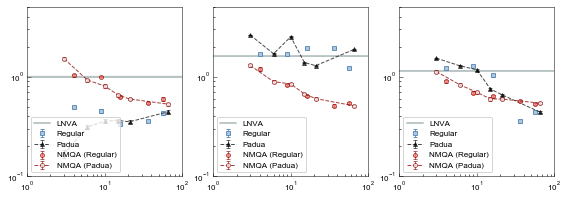

In [10]:
dataset_naive = 'naive_inf'
dataset_qslam = 'qslam_inf'
dataset_simpa = 'simpassgn_inf'
LAGR['ms'] = 4
idx_msmt_var = len(Multiples) - 1

#skip idx_truth ==0
fig, axes = plt.subplots(1, len(SIM_DICT_LIST)-1, figsize=(cm2inch(24.), cm2inch(7.9)))


for idx_truth in range(1, len(SIM_DICT_LIST)): #skip idx_truth ==0
    
    ax1 = axes[idx_truth -1 ]#skip idx_truth ==0

    ax1.axhline(y= vars()[dataset_simpa+'_exp_loss'][idx_truth, 0, idx_msmt_var], **SIMPA)
    ax1.fill_between(x=np.arange(1,101),
                     y1= vars()[dataset_simpa+'_errbar_low'][idx_truth, 0, idx_msmt_var],
                     y2= vars()[dataset_simpa+'_errbar_upp'][idx_truth, 0, idx_msmt_var],
                     facecolor='darkslategray', alpha=0.05)
    
#     ax1.errorbar(9, vars()[dataset_simpa+'_exp_loss'][idx_truth, 0, idx_msmt_var],
#              yerr=vars()[dataset_simpa+'_std_loss'][idx_truth, 0, idx_msmt_var], **SIMPA)

    ax1.errorbar(REG_SCALING, vars()[dataset_naive+'_exp_loss'][idx_truth,1:PICK_PADUA_ORDER, idx_msmt_var],
             yerr=vars()[dataset_naive +'_std_loss'][idx_truth, 1:PICK_PADUA_ORDER, idx_msmt_var], **RBF)

    ax1.errorbar(NUM_SENSOR_QUBITS, 
                 vars()[dataset_naive+'_exp_loss'][idx_truth, PICK_PADUA_ORDER :, idx_msmt_var],
                 yerr=vars()[dataset_naive+'_std_loss'][idx_truth, PICK_PADUA_ORDER :, idx_msmt_var], **LAGR)


    ax1.errorbar(REG_SCALING, 
                vars()[dataset_qslam+'_exp_loss'][idx_truth, 1:PICK_PADUA_ORDER :, idx_msmt_var],
                yerr=vars()[dataset_qslam+'_std_loss'][idx_truth, 1:PICK_PADUA_ORDER :, idx_msmt_var],**NMQAr)
    
    ax1.errorbar(NUM_SENSOR_QUBITS, 
                vars()[dataset_qslam+'_exp_loss'][idx_truth, PICK_PADUA_ORDER :, idx_msmt_var],
                yerr=vars()[dataset_qslam+'_std_loss'][idx_truth, PICK_PADUA_ORDER :, idx_msmt_var], **NMQA)

    ax1.set_yscale('log')
    ax1.set_xscale('log')
    
    if idx_truth > 0:
        ax1.set_ylim([0.1, 5])
        ax1.set_xlim([1, 100])
        
#     ax1.set(xlabel='Sensor Qubits (num)', ylabel='Inf. Norm (rad)', title=Multiples[idx_msmt_var])

    ax1.legend(loc=3, fontsize=8)
plt.savefig('FIGURES/0_SEM_uniform_final_qubitnum.svg', format='svg', dpi=900)
plt.show()

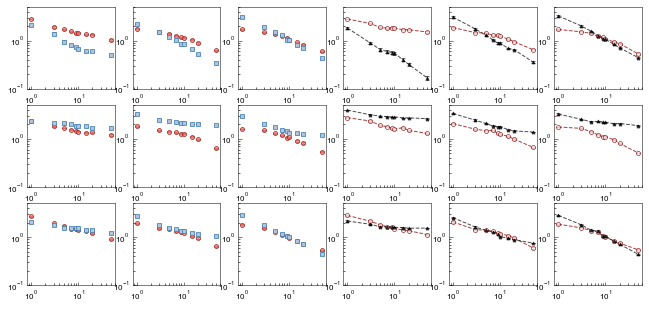

In [12]:
loss_label = ['RMS/$\pi$', 'SSIM', 'Inf']
case_titles = ['']
XLIMMAX = 50
selected_orders = [1, 3, 5, 6, 9, 11]
LAGR['ms'] = 3

for plot_metric in [2]: # 0 RMS, 1# SSIM , #2 Inf
    
    #skip idx_truth ==0
    # MAIN
#     fig, axes = plt.subplots(len(SIM_DICT_LIST)-1, len(selected_orders), figsize=(cm2inch(6*3.5), cm2inch(3*3.5 + 1)))
    # APPENDICES
    fig, axes = plt.subplots(len(SIM_DICT_LIST)-1, len(selected_orders), figsize=(cm2inch(28), cm2inch(13)))
    
    for idx_sord in range(len(selected_orders)):
        
        idx_grid = selected_orders[idx_sord]
        
        if idx_grid <=5 :
            
            pickNMQA = NMQAr
            pickNaive = RBF
        
        if idx_grid >5 :
            pickNMQA = NMQA
            pickNaive = LAGR
        
        for idx_case in range(1, len(SIM_DICT_LIST)): #skip idx_truth ==0

            idx_dataset_nmqa = plot_metric*2
            idx_dataset_naive = plot_metric*2 + 1

            axes[idx_case-1, idx_sord].errorbar(Multiples, vars()[data_labels[idx_dataset_nmqa] +'_exp_loss'][idx_case, idx_grid],
                         yerr=vars()[data_labels[idx_dataset_nmqa] +'_std_loss'][idx_case, idx_grid], **pickNMQA)

            axes[idx_case-1, idx_sord].errorbar(Multiples, vars()[data_labels[idx_dataset_naive] +'_exp_loss'][idx_case, idx_grid],
                         yerr=vars()[data_labels[idx_dataset_naive] +'_std_loss'][idx_case, idx_grid], **pickNaive)
            
            if plot_metric < 2:
                axes[idx_case, idx_sord].yaxis.set_ticks(np.arange(0., 1.1, 0.5))   
                
            if plot_metric == 2 and idx_case >0:
                axes[idx_case-1, idx_sord].set_ylim([0.1, 5])
                axes[idx_case-1, idx_sord].set_yscale('log')
                axes[idx_case-1, idx_sord].set_xscale('log')
                
plt.savefig('FIGURES/0_SEM_uniform_final_msmtnum_app.svg', format='svg', dpi=900)
plt.show()

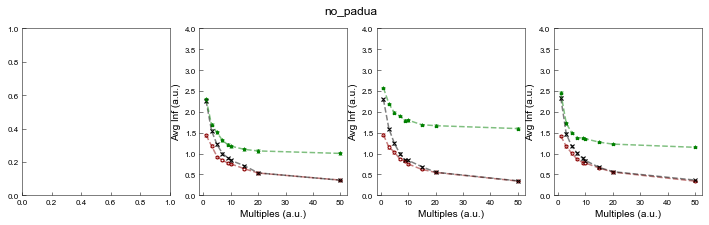

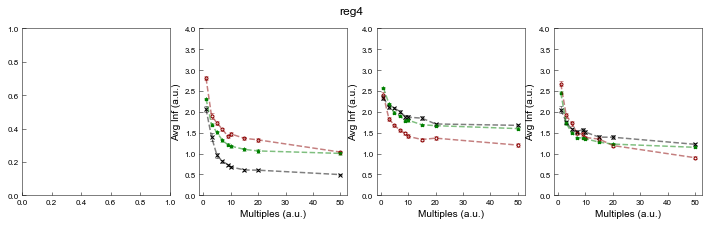

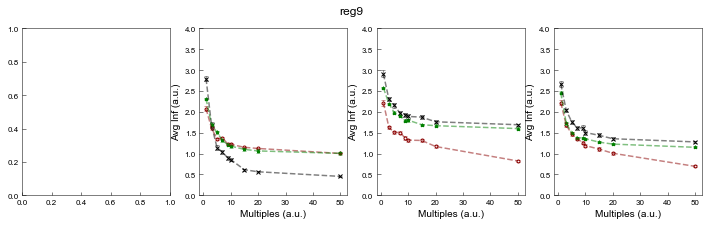

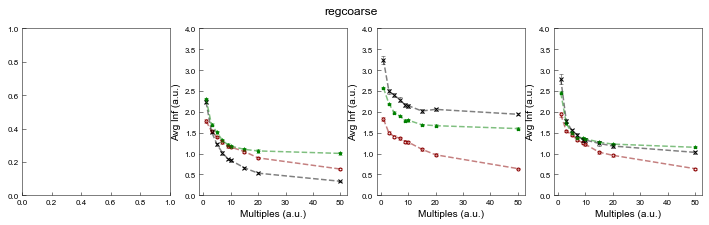

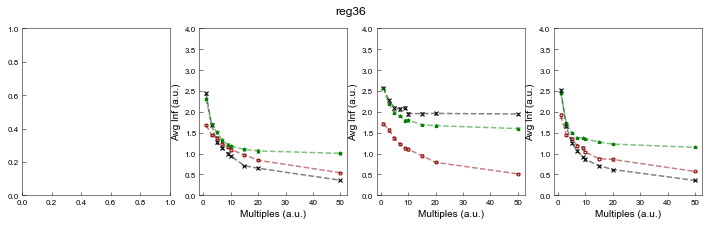

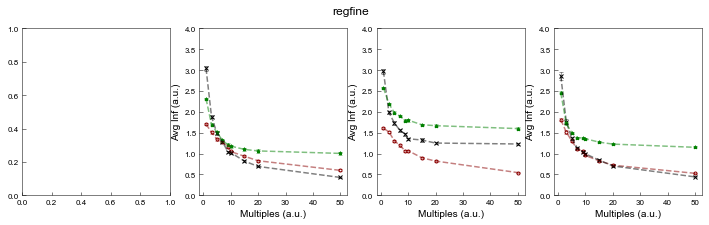

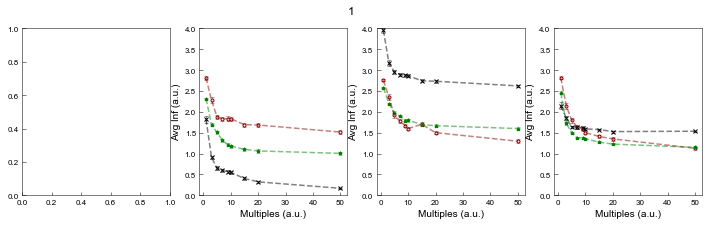

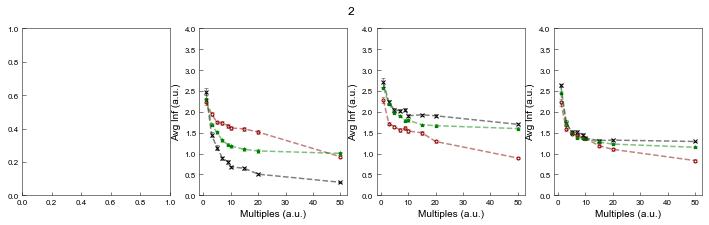

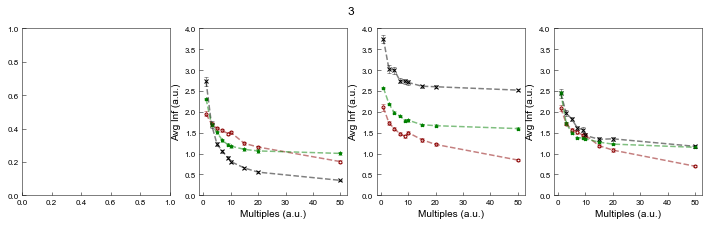

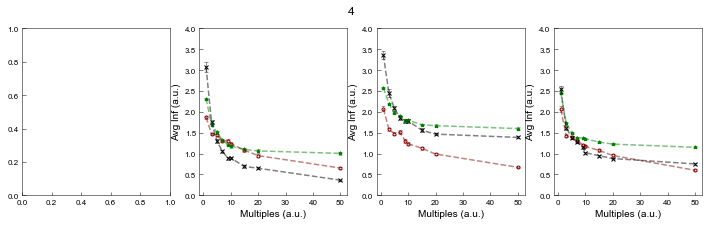

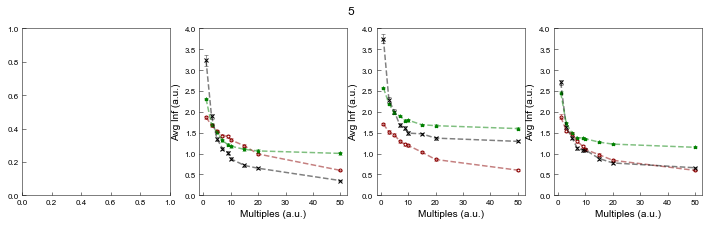

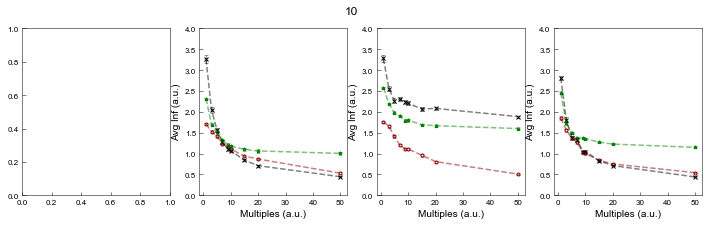

In [13]:
loss_label = ['RMS/$\pi$', 'SSIM', 'Inf']
case_titles = ['']
XLIMMAX = 50

for plot_metric in [2]: # 0 RMS, 1# SSIM , #2 Inf

    for idx_grid in range(len(GRID_ORDER)):
    

        fig, axes_ = plt.subplots(1, len(SIM_DICT_LIST), figsize=(cm2inch(30.95), cm2inch(7.8)))
        axes = np.empty_like(axes_)
        axes = np.vstack([axes, axes])
        
        fig.suptitle(get_keys(GRID_ORDER[idx_grid], '')[1])
        
        #skip idx_truth ==0
        for idx_case in range(1, len(SIM_DICT_LIST)):

            idx_dataset_nmqa = plot_metric*2
            idx_dataset_naive = plot_metric*2 + 1

            axes[0, idx_case -1 ] = axes_[idx_case]
            
            axes[0, idx_case -1 ].plot(Multiples, vars()[data_labels[idx_dataset_nmqa] +'_exp_loss'][idx_case, idx_grid],
                                   'o', ms=3, markerfacecolor='white', markeredgecolor='darkred', label='NMQA')
            axes[0, idx_case -1 ].plot( Multiples, vars()[data_labels[idx_dataset_naive] +'_exp_loss'][idx_case, idx_grid],
                                   'x', ms=3.5, c='k', label='Naive')
            
            axes[0, idx_case -1 ].plot( Multiples, vars()[dataset_simpa +'_exp_loss'][idx_case, 0],
                                   '*', ms=3.5, c='green', label='Naive')

            axes[0, idx_case -1 ].errorbar(Multiples, vars()[data_labels[idx_dataset_nmqa] +'_exp_loss'][idx_case, idx_grid],
                         yerr=vars()[data_labels[idx_dataset_nmqa] +'_std_loss'][idx_case, idx_grid],
                         alpha=0.5 , color='darkred', ls='--',capsize=2, elinewidth=0.8, markeredgewidth=0.8)

            axes[0, idx_case -1 ].errorbar(Multiples, vars()[data_labels[idx_dataset_naive] +'_exp_loss'][idx_case, idx_grid],
                         yerr=vars()[data_labels[idx_dataset_naive] +'_std_loss'][idx_case, idx_grid], 
                         alpha=0.5, color='k', ls='--', capsize=2, elinewidth=0.8, markeredgewidth=0.8)
            
            axes[0, idx_case -1 ].errorbar(Multiples, vars()[dataset_simpa +'_exp_loss'][idx_case, 0],
                         yerr=vars()[dataset_simpa +'_std_loss'][idx_case, 0], 
                         alpha=0.5, color='green', ls='--', capsize=2, elinewidth=0.8, markeredgewidth=0.8)

            if plot_metric < 2:
                axes[0, idx_case-1].yaxis.set_ticks(np.arange(0., 1.1, 0.5))   
                
            if plot_metric == 2:
                axes[0, idx_case-1].set_ylim([0, 4.])

            axes[0, idx_case-1].set_xlabel('Multiples (a.u.)')
            axes[0, idx_case-1].set_ylabel(r'Avg '+loss_label[plot_metric]+' (a.u.)')

        plt.show()